Import stuff and initialize global parameters.

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Conv2D, Flatten, Dense, LSTM, \
    MaxPooling2D
from keras.models import Sequential
from common import extract_training_data_as_stacked
from car_interfacing import CarConnection
from sklearn.metrics import explained_variance_score

IMAGE_SIZE = (64, 64, 3)

Using TensorFlow backend.


# Convolutional network
Reading data as bundles and creating initial model.

In [103]:
images, labels = extract_training_data_as_stacked("Data/20171211-185037299.h264", 
                                                  "Data/20171211-185037299.csv", 
                                                  IMAGE_SIZE)

In [7]:
images, labels = extract_training_data_as_stacked("Data/20171029-201949.h264.avi", 
                                                  "Data/20171029-201949.h264.csv", 
                                                  IMAGE_SIZE)

In [109]:
y_train = labels.as_matrix(columns=labels.columns[2:])
y_train.shape

(8725, 4)

In [110]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu', input_shape=(64, 64, 12)))
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu'))
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu'))
    model.add(Flatten())
    model.add(Dense(4, activation='linear'))

    model.compile(loss="mse", optimizer="adam")    
    return model

model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_276 (Conv2D)          (None, 62, 62, 32)        3488      
_________________________________________________________________
conv2d_277 (Conv2D)          (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_126 (MaxPoolin (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_278 (Conv2D)          (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_127 (MaxPoolin (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_279 (Conv2D)          (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_128 (MaxPoolin (None, 6, 6, 64)          0         
__________

In [111]:
history = model.fit(images, y_train, batch_size=64, epochs=10, validation_split=0.04)

Train on 8376 samples, validate on 349 samples
Epoch 1/10
8376/8376 [==============================] - 170s - loss: 0.1115 - val_loss: 0.0014
Epoch 2/10
8376/8376 [==============================] - 170s - loss: 0.0587 - val_loss: 6.6118e-04
Epoch 3/10
8376/8376 [==============================] - 162s - loss: 0.0481 - val_loss: 0.0044
Epoch 4/10
8376/8376 [==============================] - 158s - loss: 0.0422 - val_loss: 0.0012
Epoch 5/10
8376/8376 [==============================] - 162s - loss: 0.0370 - val_loss: 0.0079
Epoch 6/10
8376/8376 [==============================] - 187s - loss: 0.0342 - val_loss: 0.0014
Epoch 7/10
8376/8376 [==============================] - 173s - loss: 0.0312 - val_loss: 0.0012
Epoch 8/10
8376/8376 [==============================] - 170s - loss: 0.0281 - val_loss: 0.0079
Epoch 9/10
8376/8376 [==============================] - 177s - loss: 0.0261 - val_loss: 0.0049
Epoch 10/10
8376/8376 [==============================] - 184s - loss: 0.0243 - val_loss: 5.647

In [112]:
test_images, test_labels = extract_training_data_as_stacked("Data/20171029-201639.h264.avi", 
                                                            "Data/20171029-201639.h264.csv", 
                                                            IMAGE_SIZE)

prediction = model.predict(test_images)

### Convolutional network results
Testing prediction printout and graphs.

In [114]:
prediction

array([[ 0.09873925,  0.19729568,  0.33189699,  1.81535172],
       [ 0.06229995,  0.18825717,  0.35686088,  1.85052013],
       [ 0.03813466,  0.19362171,  0.3318457 ,  1.84357691],
       ..., 
       [-0.88659483,  0.19126537, -0.07776474,  1.66294837],
       [-0.6540876 ,  0.09294401,  0.28506628,  1.67603016],
       [-0.54202688,  0.04881433,  0.39165872,  1.75608325]], dtype=float32)

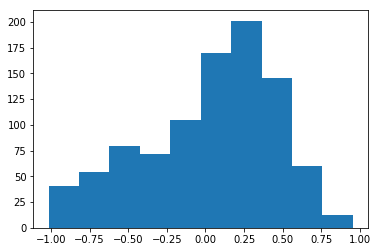

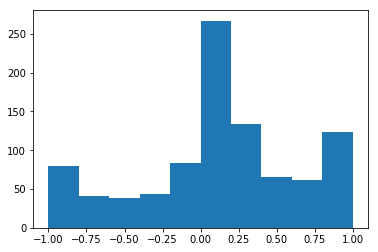

In [115]:
# Prediction histogram
plt.hist(prediction[:, 0])
plt.show()

# Test data
plt.hist(test_labels['Steering'])
plt.show()

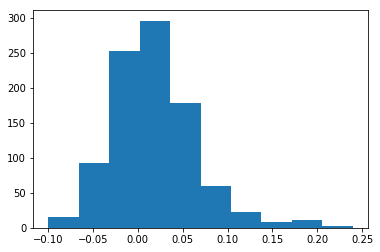

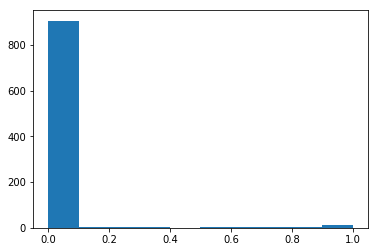

In [116]:
# Prediction histogram
plt.hist(prediction[:, 1])
plt.show()

# Test data
plt.hist(test_labels['Braking'])
plt.show()

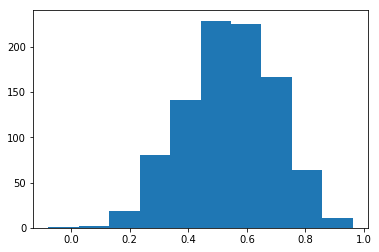

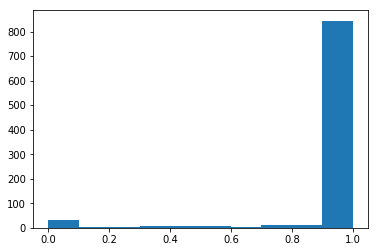

In [117]:
# Prediction histogram
plt.hist(prediction[:, 2])
plt.show()

# Test data
plt.hist(test_labels['Throttle'])
plt.show()

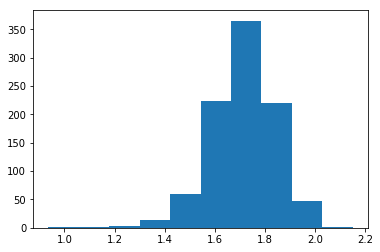

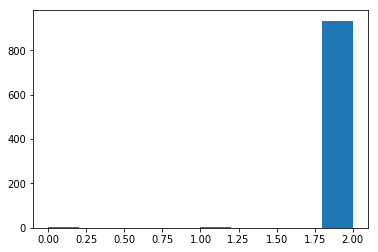

In [118]:
# Prediction histogram
plt.hist(prediction[:, 3])
plt.show()

# Test data
plt.hist(test_labels['Gear'])
plt.show()

### Result analysis
Explained variance etc.

Firstly clip incorrect values back into known bounds. Afterwards find the explained variance.

In [119]:
validation_labels = test_labels.as_matrix(columns=test_labels.columns[1: ])

clipped_prediction = np.zeros_like(prediction)

# Steering
clipped_prediction[:, 0] = np.clip(prediction[:, 0], -1, 1)
# Brakes
clipped_prediction[:, 1] = np.clip(prediction[:, 1], 0, 1)
# Throttle
clipped_prediction[:, 2] = np.clip(prediction[:, 2], 0, 1)
# Gear
clipped_prediction[:, 3] = np.round(prediction[:, 3])


print(validation_labels.shape)
print(clipped_prediction.shape)

(939, 4)
(939, 4)


In [120]:
explained_variance_score(validation_labels, clipped_prediction)

-0.48428487310948692

## K fold cross validation

In [ ]:
from common import run_kfold_cross_val

# Concatenate both videos
total_images = np.concatenate((images, test_images), axis=0)
total_labels = np.concatenate((labels, test_labels), axis=0)

total_y_train = total_labels[:, 1:-1]

results = run_kfold_cross_val(create_model, total_images, total_y_train)
print(results)
print(results.mean())
print(np.median(results))

## Saving model
Saves the model into a file and loads it again.

In [113]:
from keras.models import load_model

model.save('conv_dense_gear_bigdata.h5')
del model
model = load_model('conv_dense_gear_bigdata.h5')

## Code block to run the actual car

Not recommended, use the separate script (currently main.py) instead.


In [7]:
from PIL import Image
from keras.models import load_model

model = load_model('conv_dense_gear_bigdata.h5')
connection = CarConnection()

frame_counter = 0
processed_frames = []

while True:
    frame_counter += 1
    
    # connect to 22241 and retreive rescaled frame
    frame = connection.receive_data_from_stream()
    
    if frame is not None:
        # Normalizing frame
        normed = frame / 255
        processed_frames.append(normed)
        
        if len(processed_frames) >= 4:
            stacked_image = np.concatenate(processed_frames, axis=2)
            processed_frames.pop(0)
            
            prediction = model.predict(stacked_image[np.newaxis, :])
            pred_list = prediction.tolist()[0]
            
            # Eliminate braking element if it's too small
            pred_list[1] = pred_list[1] if pred_list[1] >= 0.4 else 0.0
            
            # Normalize throttle to be always an effective input
            pred_list[2] = 0.3 + np.clip(pred_list[2], 0, 1) * 0.5
            
            # Round gear to closest integer
            pred_list[3] = 2 if pred_list[3] >= 1.3 else 1
            
            connection.send_commands_to_car(pred_list)
                
    # Some breaking condition to kill me here
    if frame_counter >= 15000:
        break

connection.close()

KeyboardInterrupt: 

In [3]:
connection.close()